# Assignment 01: Transfer Learning with Cassava

#### **Base notebook:** 02_transfer_learning
#### **Dataset:** Cassava Leaf Disease Classification

In [2]:
import os
import json
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch
import random
import numpy as np
import seaborn as sns

In [3]:


class CassavaDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image_id"])
        image = Image.open(img_path).convert("RGB")
        label = int(row["label"])
        if self.transform:
            image = self.transform(image)
        return image, label


class CassavaDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, csv_path, json_path, batch_size=64, num_workers=2):
        super().__init__()
        self.data_dir = data_dir
        self.csv_path = csv_path
        self.json_path = json_path
        self.batch_size = batch_size
        self.num_workers = num_workers

        # Transforms (standard ImageNet normalization)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to match common CNN input
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def setup(self, stage=None):
        # Load metadata
        df = pd.read_csv(self.csv_path)
        with open(self.json_path, "r") as f:
            self.class_mapping = json.load(f)

        # Split according to 'set' column
        train_df = df[df["set"] == "train"]
        val_df = df[df["set"] == "val"]
        test_df = df[df["set"] == "test"]

        # Create datasets
        self.train_ds = CassavaDataset(train_df, os.path.join(self.data_dir, "images"), transform=self.transform)
        self.val_ds = CassavaDataset(val_df, os.path.join(self.data_dir, "images"), transform=self.transform)
        self.test_ds = CassavaDataset(test_df, os.path.join(self.data_dir, "images"), transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

In [4]:
# dm = CassavaDataModule(
#     data_dir="datasets/cassava",
#     csv_path="datasets/cassava/cassava_split.csv",
#     json_path="datasets/cassava/label_num_to_disease_map.json",
#     batch_size=64
# )

# dm.setup()

# for imgs, labels in dm.train_dataloader():
#     print(imgs.shape, labels.shape)
#     break


### Exploratory Data Analysis (EDA) of the dataset

What classes do we have, and what do they look like?
- Cassava Bacterial Blight (CBB)
- Cassava Brown Streak Disease (CBSD)
- Cassava Green Mottle (CGM)
- Cassava Mosaic Disease (CMD)
- Healthy

In [5]:
dm = CassavaDataModule(
    data_dir="cassava",
    csv_path="cassava/cassava_split.csv",
    json_path="cassava/label_num_to_disease_map.json",
    batch_size=64
)

dm.setup()

# --- Load class mapping ---
with open(dm.json_path, "r") as f:
    class_mapping = json.load(f)
inv_mapping = {int(k): v for k, v in class_mapping.items()}

# --- Access a few samples from the training dataset ---
dataset = dm.train_ds  # you can also use val_ds or test_ds
num_classes = len(inv_mapping)
samples_per_class = 9

# Collect example indices for each class
indices_by_class = {i: [] for i in range(num_classes)}
for idx in range(len(dataset)):
    _, label = dataset[idx]
    label = int(label)
    if len(indices_by_class[label]) < samples_per_class:
        indices_by_class[label].append(idx)
    if all(len(v) == samples_per_class for v in indices_by_class.values()):
        break


# Directory to save the images
output_dir = "cassava_classes_images"
os.makedirs(output_dir, exist_ok=True)

# --- Plot ---
# --- Save separate 3x3 grids for each class ---
for class_id, class_name in inv_mapping.items():
    fig, axs = plt.subplots(3, 3, figsize=(9, 9))
    axs = axs.flatten()
    
    for i, idx in enumerate(indices_by_class[class_id]):
        img, _ = dataset[idx]
        # Undo normalization for visualization
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axs[i].imshow(img)
        axs[i].axis("off")
    
    # Turn off unused subplots if fewer than 9 images
    for j in range(i + 1, 9):
        axs[j].axis("off")
    
    fig.suptitle(class_name, fontsize=16)
    
    # Save each figure
    save_path = os.path.join(output_dir, f"{class_name.replace(' ', '_')}.png")
    fig.savefig(save_path, bbox_inches="tight", pad_inches=0.1)
    plt.close(fig)

print(f"Saved images for each class in: {output_dir}")



Saved images for each class in: cassava_classes_images


What is the class distribution?

/tmp/ipykernel_465254/2719116094.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


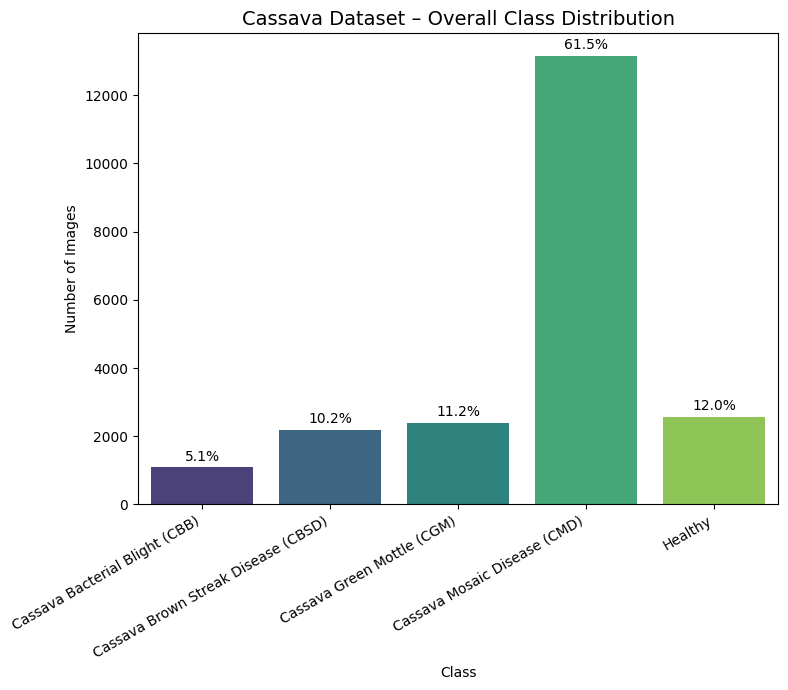

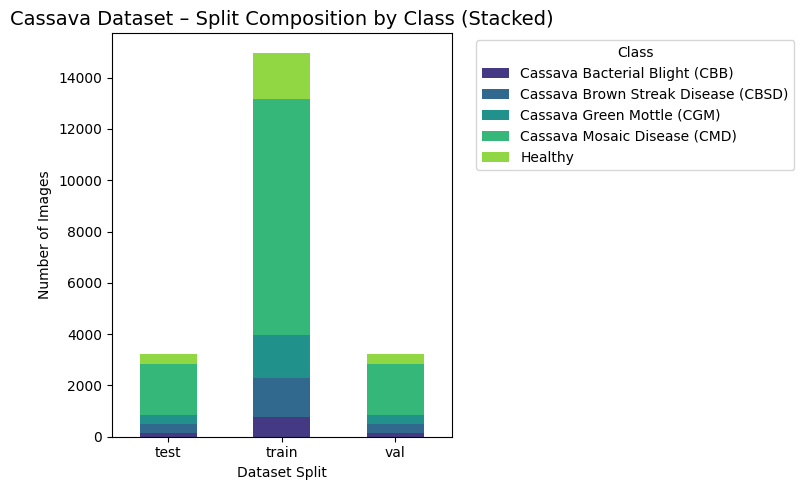

In [6]:
df = pd.read_csv(dm.csv_path)
with open(dm.json_path, "r") as f:
    class_mapping = json.load(f)

inv_mapping = {int(k): v for k, v in class_mapping.items()}
df["class_name"] = df["label"].map(inv_mapping)

# --- 1️⃣ Overall class distribution ---
plt.figure(figsize=(8, 7))

# Order of classes
class_order = [inv_mapping[i] for i in sorted(inv_mapping.keys())]

# Plot bars
ax = sns.countplot(
    data=df,
    x="class_name",
    order=class_order,
    palette="viridis"
)

plt.title("Cassava Dataset – Overall Class Distribution", fontsize=14)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=30, ha="right")

# Add percentages on top of bars
total = len(df)
for p in ax.patches:
    count = p.get_height()
    percentage = count / total * 100
    ax.text(
        x=p.get_x() + p.get_width() / 2,  # bar center
        y=count + total*0.005,            # slightly above the bar
        s=f"{percentage:.1f}%",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

# --- 2️⃣ Class distribution per split (train/val/test) ---
pivot_df = (
    df.groupby(["set", "class_name"])
      .size()
      .unstack(fill_value=0)[[inv_mapping[i] for i in sorted(inv_mapping.keys())]]
)

# Plot
pivot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 5),
    color=sns.color_palette("viridis", n_colors=len(inv_mapping))
)

plt.title("Cassava Dataset – Split Composition by Class (Stacked)", fontsize=14)
plt.xlabel("Dataset Split")
plt.ylabel("Number of Images")
plt.xticks(rotation=0)
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Are the labels reliable?

Some users have analyzed the label reliability and found that around
8% of the images are mislabeled.

The Cassava Mosaic Disease (CMD) class is the most accurately
labeled, with 98% of its labels correct.

The Healthy and Cassava Bacterial Blight (CBB) classes are the least
reliable, with approximately 21% of their images mislabeled.

### Develop and train a Convolutional Neural Network (CNN) using PyTorch Lightning, testing different transfer learning approaches.

Write a short report including the EDA, the results obtained from the transfer
learning experiments, and conclusions explaining why certain transfer learning
strategies perform better than others in this specific scenario.